#Transfer Learning: Fine Tununing
In this notebook we will analize in detail the transfer Learining
 using fine tuning using, which means to retrain a part of the parameters from the uploaded model we want tu use.

In [1]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2022-01-17 15:06:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-17 15:06:11 (62.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2022-01-17 15:06:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 172.253.123.128, 142.250.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   246MB/s    in 0.7s    

2022-01-17 15:06:14 (246 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [4]:
# Create data inputs
# Note that we are not using anymore ImageDataGenerator for performance reasons  
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


# Building Model 0 using Keras Functional API

In [5]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20220117-150622


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/5
24/24 [==============================] - 22s 266ms/step - loss: 1.8997 - accuracy: 0.4027 - val_loss: 1.3610 - val_accuracy: 0.6990
Epoch 2/5
24/24 [==============================] - 5s 196ms/step - loss: 1.1483 - accuracy: 0.7307 - val_loss: 0.9436 - val_accuracy: 0.7845
Epoch 3/5
24/24 [==============================] - 5s 174ms/step - loss: 0.8460 - accuracy: 0.8093 - val_loss: 0.7957 - val_accuracy: 0.7862
Epoch 4/5
24/24 [==============================] - 5s 173ms/step - loss: 0.6888 - accuracy: 0.8387 - val_loss: 0.6938 - val_accuracy: 0.8273
Epoch 5/5
24/24 [==============================] - 4s 171ms/step - loss: 0.5930 - accuracy: 0.8667 - val_loss: 0.6377 - val_accuracy: 0.8388


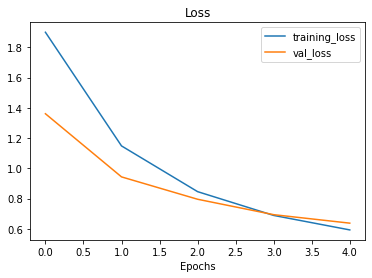

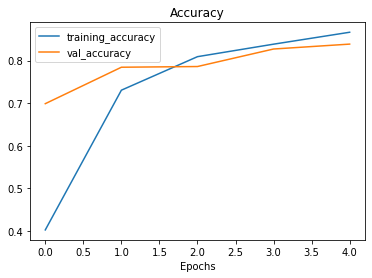

In [6]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

#Running a series of transfer learning experiments

In [7]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2022-01-17 15:07:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.134.128, 74.125.139.128, 173.194.210.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.134.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   212MB/s    in 0.6s    

2022-01-17 15:07:10 (212 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [8]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

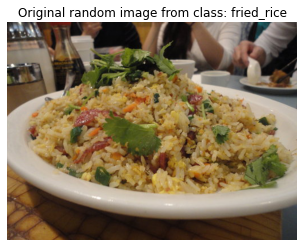

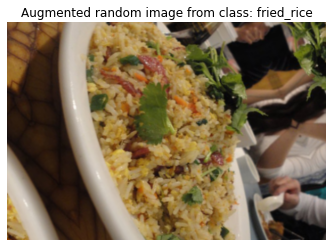

In [10]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

#Model 1
Feature extraction transfer learning on 1% of the data with data augmentation

In [11]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220117-150715
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


3/3 [==============================] - 12s 2s/step - loss: 2.3864 - accuracy: 0.0571 - val_loss: 2.2391 - val_accuracy: 0.1480
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1296 - accuracy: 0.3000 - val_loss: 2.1070 - val_accuracy: 0.2714
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9160 - accuracy: 0.4571 - val_loss: 2.0272 - val_accuracy: 0.3191
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7693 - accuracy: 0.6000 - val_loss: 1.9247 - val_accuracy: 0.3947
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6259 - accuracy: 0.6429 - val_loss: 1.8308 - val_accuracy: 0.4539


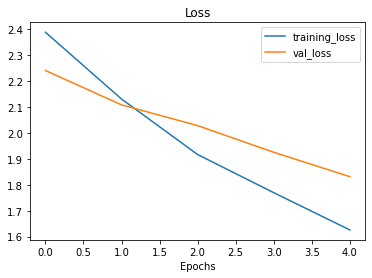

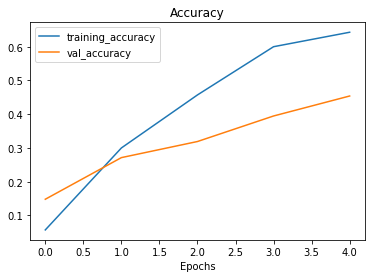

In [12]:
# How does the model go with a data augmentation layer with 1% of data
plot_loss_curves(history_1_percent)

#Model 2
Feature extraction transfer learning with 10% of data and data augmentation con Model Checkpoint Callback

In [13]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [14]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [15]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [17]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220117-150756
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0007 - accuracy: 0.3493
Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 19s 509ms/step - loss: 2.0007 - accuracy: 0.3493 - val_loss: 1.4980 - val_accuracy: 0.6579
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3780 - accuracy: 0.6547
Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 443ms/step - loss: 1.3780 - accuracy: 0.6547 - val_loss: 1.0481 - val_accuracy: 0.7763
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0710 - accuracy: 0.7493
Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 390ms/step - loss: 1.0710 - accuracy: 0.7493 - val_loss: 0.8557 - val_accura

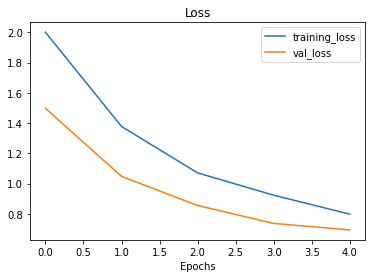

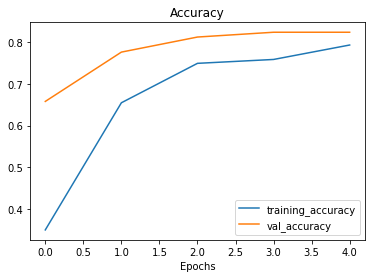

In [18]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

#Model 3
Fine-tuning an existing model on 10% of the data

In [20]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [21]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name expe

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220117-151120
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - 19s 455ms/step - loss: 0.6876 - accuracy: 0.8200 - val_loss: 0.5410 - val_accuracy: 0.8322
Epoch 6/10
24/24 [==============================] - 9s 364ms/step - loss: 0.5914 - accuracy: 0.7987 - val_loss: 0.5102 - val_accuracy: 0.8322
Epoch 7/10
24/24 [==============================] - 9s 348ms/step - loss: 0.5350 - accuracy: 0.8307 - val_loss: 0.4992 - val_accuracy: 0.8454
Epoch 8/10
24/24 [==============================] - 9s 358ms/step - loss: 0.4674 - accuracy: 0.8507 - val_loss: 0.5043 - val_accuracy: 0.8273
Epoch 9/10
24/24 [==============================] - 9s 377ms/step - loss: 0.4398 - accuracy: 0.8733 - val_loss: 0.4644 - val_accuracy: 0.8470
Epoch 10/10
24/24 [==============================] - 8s 302ms/step - loss: 0.3781 - accuracy: 0.8907 - val_loss: 0.4335 - val_accuracy: 0.8618


In [22]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.34933334589004517, 0.6546666622161865, 0.7493333220481873, 0.7586666941642761, 0.7933333516120911, 0.8199999928474426, 0.7986666560173035, 0.8306666612625122, 0.8506666421890259, 0.8733333349227905, 0.890666663646698]


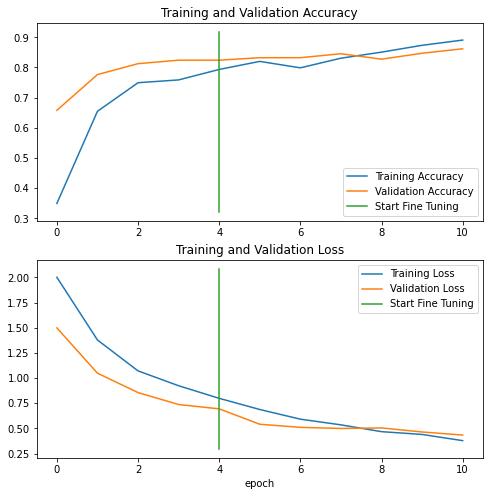

In [23]:
compare_historys(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

#Model 4
Fine-tuning an existing model all of the data

In [25]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2022-01-17 15:14:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 173.194.210.128, 173.194.211.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   200MB/s    in 2.5s    

2022-01-17 15:14:57 (200 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [26]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [27]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # divide learning rate by 10 for fine-tuning
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [28]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20220117-151634
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


235/235 [==============================] - 63s 237ms/step - loss: 0.6645 - accuracy: 0.7856 - val_loss: 0.4163 - val_accuracy: 0.8553
Epoch 6/10
235/235 [==============================] - 50s 211ms/step - loss: 0.5762 - accuracy: 0.8180 - val_loss: 0.3875 - val_accuracy: 0.8668
Epoch 7/10
235/235 [==============================] - 46s 193ms/step - loss: 0.5194 - accuracy: 0.8353 - val_loss: 0.3713 - val_accuracy: 0.8684
Epoch 8/10
235/235 [==============================] - 44s 186ms/step - loss: 0.4769 - accuracy: 0.8528 - val_loss: 0.3477 - val_accuracy: 0.8816
Epoch 9/10
235/235 [==============================] - 41s 171ms/step - loss: 0.4435 - accuracy: 0.8561 - val_loss: 0.3642 - val_accuracy: 0.8816
Epoch 10/10
235/235 [==============================] - 38s 161ms/step - loss: 0.4115 - accuracy: 0.8679 - val_loss: 0.3855 - val_accuracy: 0.8717


5
11
[0.34933334589004517, 0.6546666622161865, 0.7493333220481873, 0.7586666941642761, 0.7933333516120911, 0.7856000065803528, 0.8180000185966492, 0.8353333473205566, 0.8528000116348267, 0.8561333417892456, 0.8678666949272156]


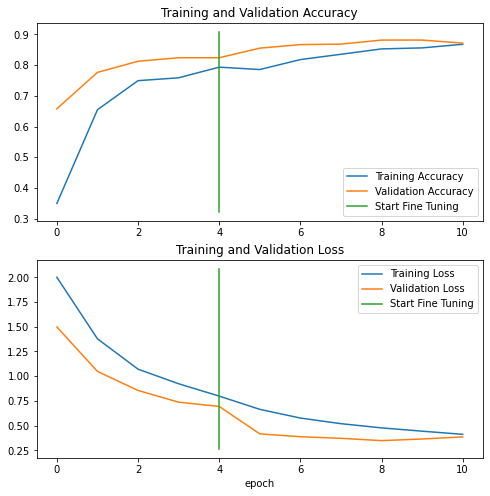

In [29]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

#Esercizio
Creo un modello simile a a model 2 ma lo traino per 10 epoche poi provo il fine tuning per 20 poi 30 livelli e traino per altre 10 epoche.
Per il tutto uso il Food Vision 10%

In [39]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_exercise = tf.keras.Model(inputs, outputs)

# Compile
model_exercise.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [40]:
# Fit the model saving checkpoints every epoch
initial_epochs_10 = 10
history_exercise = model_exercise.fit(train_data_10_percent,
                                          epochs=initial_epochs_10,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220117-161350
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 2.0365 - accuracy: 0.2920
Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 15s 331ms/step - loss: 2.0365 - accuracy: 0.2920 - val_loss: 1.5122 - val_accuracy: 0.6562
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.3977 - accuracy: 0.6427
Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 6s 239ms/step - loss: 1.3977 - accuracy: 0.6427 - val_loss: 1.0741 - val_accuracy: 0.7763
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 1.1029 - accuracy: 0.7173
Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 6s 253ms/step - loss: 1.1029 - accuracy: 0.7173 - val_loss: 0.8672 - val_accur

In [41]:
#Unfreezing 20 layers
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-20]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_exercise.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [42]:
# Fine tune for another 5 epochs
fine_tune_epochs_10 = initial_epochs_10 + 10

# Refit the model (same as model_2 except with more trainable layers)
history_fine_exercise_20 = model_exercise.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs_10,
                                               validation_data=test_data,
                                               initial_epoch=history_exercise.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name expe

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220117-161515
Epoch 10/20


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - 14s 302ms/step - loss: 0.5153 - accuracy: 0.8640 - val_loss: 0.5505 - val_accuracy: 0.8207
Epoch 11/20
24/24 [==============================] - 6s 216ms/step - loss: 0.3844 - accuracy: 0.8827 - val_loss: 0.4879 - val_accuracy: 0.8503
Epoch 12/20
24/24 [==============================] - 6s 231ms/step - loss: 0.3433 - accuracy: 0.8947 - val_loss: 0.4844 - val_accuracy: 0.8520
Epoch 13/20
24/24 [==============================] - 6s 210ms/step - loss: 0.2999 - accuracy: 0.9160 - val_loss: 0.5128 - val_accuracy: 0.8388
Epoch 14/20
24/24 [==============================] - 6s 250ms/step - loss: 0.2410 - accuracy: 0.9373 - val_loss: 0.4724 - val_accuracy: 0.8668
Epoch 15/20
24/24 [==============================] - 6s 245ms/step - loss: 0.2010 - accuracy: 0.9533 - val_loss: 0.4974 - val_accuracy: 0.8553
Epoch 16/20
24/24 [==============================] - 6s 247ms/step - loss: 0.1851 - accuracy: 0.9533 - val_loss: 0.5264 - val_accuracy: 0.8454
Epoch 17/2

In [43]:
#PROVO CON 30 LIVELLI INVECE DI 20
#Unfreezing 30 layers
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-30]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_exercise.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [44]:
# Fine tune for another 5 epochs
fine_tune_epochs_30 = 20 + 10

# Refit the model (same as model_2 except with more trainable layers)
history_fine_exercise_30 = model_exercise.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs_30,
                                               validation_data=test_data,
                                               initial_epoch=history_fine_exercise_20.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name expe

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220117-161649
Epoch 20/30
24/24 [==============================] - 14s 302ms/step - loss: 0.1029 - accuracy: 0.9680 - val_loss: 0.5355 - val_accuracy: 0.8569
Epoch 21/30
24/24 [==============================] - 6s 234ms/step - loss: 0.0887 - accuracy: 0.9760 - val_loss: 0.5933 - val_accuracy: 0.8339
Epoch 22/30
24/24 [==============================] - 6s 244ms/step - loss: 0.0919 - accuracy: 0.9773 - val_loss: 0.5167 - val_accuracy: 0.8536
Epoch 23/30
24/24 [==============================] - 6s 237ms/step - loss: 0.0516 - accuracy: 0.9893 - val_loss: 0.5834 - val_accuracy: 0.8454
Epoch 24/30
24/24 [==============================] - 6s 223ms/step - loss: 0.0612 - accuracy: 0.9853 - val_loss: 0.6939 - val_accuracy: 0.8273
Epoch 25/30
24/24 [==============================] - 6s 228ms/step - loss: 0.0642 - accuracy: 0.9827 - val_loss: 0.6118 - val_accuracy: 0.8438
Epoch 26/30
24/24 [==========================

10
21
[0.2919999957084656, 0.6426666378974915, 0.7173333168029785, 0.7639999985694885, 0.7773333191871643, 0.8199999928474426, 0.8479999899864197, 0.8333333134651184, 0.8266666531562805, 0.8640000224113464, 0.8640000224113464, 0.8826666474342346, 0.8946666717529297, 0.9160000085830688, 0.937333345413208, 0.95333331823349, 0.95333331823349, 0.9586666822433472, 0.9493333101272583, 0.9746666550636292, 0.9706666469573975]


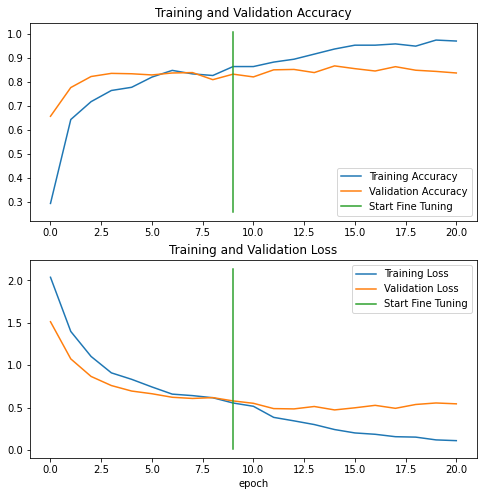

11
22
[0.8640000224113464, 0.8826666474342346, 0.8946666717529297, 0.9160000085830688, 0.937333345413208, 0.95333331823349, 0.95333331823349, 0.9586666822433472, 0.9493333101272583, 0.9746666550636292, 0.9706666469573975, 0.9679999947547913, 0.9760000109672546, 0.9773333072662354, 0.9893333315849304, 0.9853333234786987, 0.9826666712760925, 0.9853333234786987, 0.9933333396911621, 0.9906666874885559, 0.9879999756813049, 0.9946666955947876]


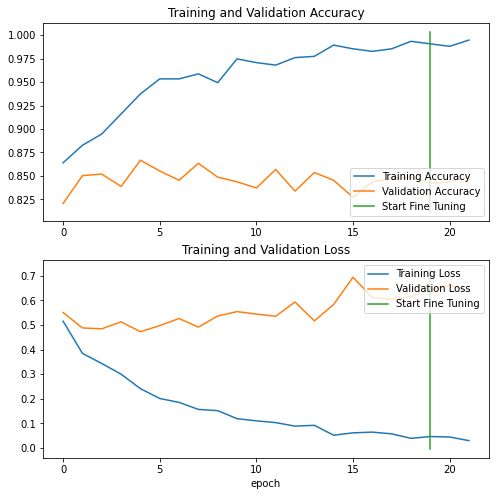

In [45]:
compare_historys(original_history=history_exercise,
                 new_history=history_fine_exercise_20,
                 initial_epochs=10)
compare_historys(original_history=history_fine_exercise_20,
                 new_history=history_fine_exercise_30,
                 initial_epochs=20)